## Notebook to generate collision rate violators for any RMG job while running

In [1]:
import logging
import numpy as np
import os
import sys

In [2]:
import os, sys
rmg_path = os.getenv('RMGpy')
if rmg_path not in sys.path:
    sys.path.append(rmg_path)
sys.path

import rmgpy
from rmgpy.chemkin import load_chemkin_file
from rmgpy.rmgobject import RMGObject, expand_to_dict, recursive_make_object

print(f"RMG-Py Version {rmgpy.__version__}")
print(rmgpy.__file__)

RDKit WARNING: [21:07:16] Enabling RDKit 2019.09.1 jupyter extensions


RMG-Py Version 3.0.0
/Users/rwest/Code/RMG-Py/rmgpy/__init__.py


In [3]:
chemkin_file = '../RMG-model/chemkin/chem_annotated-gas.inp'
chemkin_folder = os.path.split(chemkin_file)[0]
species_dictionary_file = os.path.join(chemkin_folder, 'species_dictionary.txt')
transport_file = os.path.join(chemkin_folder, 'tran.dat')

In [4]:
species, reactions = rmgpy.chemkin.load_chemkin_file(
                    chemkin_file, species_dictionary_file,transport_path=transport_file,
                    check_duplicates=False, use_chemkin_names=True,read_comments=True)



In [5]:
species_dict = {rmgpy.chemkin.get_species_identifier(s): s for s in species}
species_dict.keys()

dict_keys(['Ne', 'H4N2O2(2)', 'NH2OH(3)', 'HNO3(4)', 'CH3OH(5)', 'H2O(6)', 'N2(7)', 'O2(8)', 'CO2(9)', 'H2(10)', 'CO(11)', 'C2H6(12)', 'CH2O(13)', 'CH3(14)', 'C3H8(15)', 'H(16)', 'C2H5(17)', 'HCO(18)', 'CH3CHO(19)', 'OH(20)', 'C2H4(21)', 'CH4(24)', 'O(33)', 'HO2(36)', 'H2O2(37)', 'CH2(39)', 'CH2(S)(40)', 'CH(41)', 'CH2OH(42)', 'CH3O(43)', 'CH3OOH(51)', 'NH2(82)', 'NH3(83)', 'NH(84)', 'HNO(85)', 'H2NO(86)', 'NO(89)', 'NNH(90)', 'HONO(91)', 'NO2(92)', 'HNOH(94)', 'HNO2(95)', 'NO3(96)', 'N2H2(97)', 'H2N2(98)', 'N2H3(99)', 'N2H4(100)', 'S(125)', 'S(131)', 'S(132)', 'NH(163)', 'H3N2O(193)', 'S(194)', 'H2NO2(195)', 'S(196)', 'S(197)', 'HNO3(198)', 'H2NO3(244)', 'H2NO3(245)', 'ONCDO(257)', 'S(263)', 'S(264)', 'H2NO4(269)', 'H2NO4(270)', 'HNO(380)', 'H2N2O(381)', 'H2N2O(382)', 'H2N2O(383)', 'H3N2O(384)', 'NNDO(385)', 'H3N2O(386)', 'H3N2O(387)', 'H4N2O(393)', 'NNO(394)', 'S(395)', 'S(396)', 'S(397)', 'S(398)', 'S(429)', 'S(432)', 'S(433)', 'S(434)', 'NO(435)', 'HN2O(436)', 'HN2O(437)', 'H2N2O(4

In [6]:
def check_collision_limit_violation(self, t_min, t_max, p_min, p_max):
        """
        Warn if a core reaction violates the collision limit rate in either the forward or reverse direction
        at the relevant extreme T/P conditions. Assuming a monotonic behaviour of the kinetics.
        Returns a list with the reaction object and the direction in which the violation was detected.
        """
        conditions = [[t_min, p_min]]
        if t_min != t_max:
            conditions.append([t_max, p_min])
        if self.kinetics.is_pressure_dependent() and p_max != p_min:
            conditions.append([t_min, p_max])
            if t_min != t_max:
                conditions.append([t_max, p_max])
        logging.debug("Checking whether reaction {0} violates the collision rate limit...".format(self))
        violator_list = []
        kf_list = []
        kr_list = []
        collision_limit_f = []
        collision_limit_r = []
        for condition in conditions:
            if len(self.reactants) >= 2:
                try:
                    collision_limit_f.append(self.calculate_coll_limit(temp=condition[0], reverse=False))
                except ValueError:
                    continue
                else:
                    kf_list.append(self.get_rate_coefficient(condition[0], condition[1]))
            if len(self.products) >= 2:
                try:
                    collision_limit_r.append(self.calculate_coll_limit(temp=condition[0], reverse=True))
                except ValueError:
                    continue
                else:
                    kr_list.append(self.generate_reverse_rate_coefficient().get_rate_coefficient(condition[0], condition[1]))
        if len(self.reactants) >= 2:
            for i, k in enumerate(kf_list):
                if k > collision_limit_f[i]:
                    ratio = k / collision_limit_f[i]
                    condition = '{0} K, {1:.1f} bar'.format(conditions[i][0], conditions[i][1] / 1e5)
                    violator_list.append([self, 'forward', ratio, condition])
        if len(self.products) >= 2:
            for i, k in enumerate(kr_list):
                if k > collision_limit_r[i]:
                    ratio = k / collision_limit_r[i]
                    condition = '{0} K, {1:.1f} bar'.format(conditions[i][0], conditions[i][1] / 1e5)
                    violator_list.append([self, 'reverse', ratio, condition])
        return violator_list

In [7]:
import numpy as np
np.linalg.LinAlgError

numpy.linalg.linalg.LinAlgError

In [8]:
violators = []
for r in reactions:
    try:
        v = check_collision_limit_violation(r, 150+273,1000, 1e5, 30e5)
    except np.linalg.LinAlgError:
        print(f"LinAlgError checking {r}")
    if v:
        print(r)
        violators.extend(v)

H2NO3(245) + S(489) <=> HNO3(4) + S(429)
S(489) + HCO(18) <=> S(429) + CO(11)
S(489) + C2H5(17) <=> S(429) + C2H4(21)
H3N2O(193) + S(489) <=> NNDO(385) + S(429)
H2NO3(244) + S(489) <=> HNO3(4) + S(429)
NH2(82) + NH2(82) <=> H(16) + N2H3(99)
H3N2O(193) + S(489) <=> H2N2O(382) + S(429)
S(489) + CH2OH(42) <=> S(429) + CH2O(13)
H3N2O(193) + CH2OH(42) <=> S(1553)
HNOH(94) + CH2OH(42) <=> ONCO(1088)
S(489) + CH2OH(42) <=> S(1564)
O2(8) + HNOH(94) <=> H2NO3(546)
HNO3(198) + S(489) <=> NO3(96) + S(429)
HNO3(705) + CH2OH(42) <=> H2NO3(245) + CH2O(13)
HNO3(705) + H2NO3(244) <=> HNO3(4) + H2NO3(244)
HNO3(705) + H2NO3(245) <=> HNO3(4) + H2NO3(244)
HO2(36) + HNO3(705) <=> O2(8) + H2NO3(244)
HNO3(705) + C2H5(17) <=> H2NO3(244) + C2H4(21)
HNO3(705) + H3N2O(193) <=> H2NO3(244) + NNDO(385)
HNO3(705) + H4N2O2(2) <=> H2NO3(244) + S(196)
HNO3(705) + H3N2O(193) <=> H2NO3(244) + H2N2O(382)
HNO3(705) + S(196) <=> NO3(96) + H4N2O2(2)
HNO3(705) + S(197) <=> NO3(96) + H4N2O2(2)
HNO3(705) + S(194) <=> NO3(96) + 

H2NO(86) + C2H5(17) <=> H3NO(1261) + C2H4(21)
H2NO(86) + H3N2O(193) <=> H2N2O(382) + H3NO(1261)
H2NO(86) + H3N2O(193) <=> NNDO(385) + H3NO(1261)
H2NO(86) + H2N2O(381) <=> HN2O(436) + H3NO(1261)
H2NO(86) + HNOH(94) <=> HNO(85) + H3NO(1261)
H2NO(86) + N2H3(99) <=> N2H2(97) + H3NO(1261)
H2NO(86) + N2H3(99) <=> H2N2(98) + H3NO(1261)
H2NO(86) + H2NO3(245) <=> HNO3(4) + H3NO(1261)
H2NO(86) + H2NO3(244) <=> HNO3(4) + H3NO(1261)
H2NO(86) + H2NO(86) <=> HNO(85) + H3NO(1261)
HNO3(198) + H2NO(86) <=> NO3(96) + H3NO(1261)
H2NO(86) + CH2OH(42) <=> H3NO(1261) + CH2O(13)
HNO3(705) + H2NO(86) <=> NO3(96) + H3NO(1261)
H2NO(86) + H3N2O(386) <=> NNDO(385) + H3NO(1261)
H2NO(86) + H3N2O(387) <=> H2N2O(382) + H3NO(1261)
H2NO(86) + H2N2O(383) <=> HN2O(436) + H3NO(1261)
H2NO(86) + NH3NH(572) <=> H3NO(1261) + N2H3(99)
H2NO(86) + H2NO2(623) <=> HNO2(95) + H3NO(1261)
H2NO(86) + H2NO2(623) <=> HONO(91) + H3NO(1261)
H2NO(86) + H2NO2(818) <=> HONO(91) + H3NO(1261)
H3NO3(824) + H3N2(567) <=> H2NO3(244) + NH3NH(572)


S(445) + S(263) <=> S(395) + S(132)
S(489) + S(445) <=> S(749) + S(395)
S(825) <=> HNO3(1929) + H2NO3(244)
NO3(1831) + HNO3(705) <=> NO3(96) + HNO3(1929)
HN2O5(891) <=> NO2(92) + HNO3(1929)
HNO3(705) + H3N2O(386) <=> NO3(96) + S(1985)
H3N2O(386) + S(263) <=> S(1985) + S(132)
O2(8) + S(489) <=> HO2(36) + S(748)
H3N2O(193) + S(489) <=> S(748) + H4N2O(393)
N2H3(99) + S(489) <=> S(748) + NH3NH(572)
S(489) + S(196) <=> S(748) + H4N2O2(2)
S(489) + S(196) <=> S(748) + S(647)
S(489) + S(489) <=> S(748) + S(429)
H2NO(86) + S(489) <=> S(748) + H3NO(1261)
S(489) + S(197) <=> S(748) + S(616)
HNO3(705) + S(489) <=> H2NO3(244) + S(748)
HNO3(705) + S(489) <=> H2NO3(245) + S(748)
H3N2O(386) + S(489) <=> S(748) + S(1985)
NO3(1344) + S(489) <=> HNO3(198) + S(748)
S(489) + S(1555) <=> S(748) + S(1553)
H2N2O(383) + S(489) <=> S(748) + H3N2O(384)
H2N2(439) + S(489) <=> S(748) + H3N2(567)
S(489) + S(2204) <=> S(748) + NOON(1258)
S(639) + S(489) <=> S(748) + S(194)
S(639) + S(489) <=> S(748) + S(642)
S(640) 

H2NO3(819) + S(446) <=> OONDO(938) + S(396)
H2NO3(706) + S(446) <=> OONDO(938) + S(396)
NO2(888) + S(489) <=> HNO2(8021) + S(748)
NO2(888) + HNO3(705) <=> NO3(96) + HNO2(8021)
H3N2O(444) + HCO(18) <=> NNDO(385) + CH2O(13)
H2N2O(381) + S(489) <=> S(748) + H3N2O(444)
NO3(1344) + H3N2O(444) <=> HNO3(198) + NNDO(385)
HNO3(705) + H2N2O(381) <=> NO3(96) + H3N2O(444)
H3N2O(444) + S(445) <=> NNDO(385) + S(395)
H2N2O(381) + S(263) <=> H3N2O(444) + S(132)
HNO3(705) + H3N2O(444) <=> NO3(96) + S(1985)
H(16) + NH2(82) <=> NH(163) + H2(10)
O(33) + NH2(82) <=> OH(20) + NH(163)
O(33) + NH2(82) <=> OH(20) + NH(163)
OH(20) + NH2(82) <=> NH(163) + H2O(6)
NH2(82) + NH2(82) <=> NH(163) + NH3(83)
HNO3(705) + S(398) <=> NO3(96) + S(860)
HNO3(705) + S(2219) <=> NO3(96) + S(543)
HNO3(705) + S(2219) <=> NO3(96) + S(1262)
S(2219) + S(196) <=> OONDN(638) + S(1262)
S(2219) + S(263) <=> S(1262) + S(132)
S(2219) + S(489) <=> S(748) + S(1262)
S(196) + S(1032) <=> H4N2O2(2) + S(125)
O2(8) + S(1032) <=> HO2(36) + S(125

S(1105) + S(1032) <=> S(1102) + S(125)
S(197) + S(1105) <=> OONDN(638) + S(1102)
S(196) + S(1105) <=> OONDN(638) + S(1102)
S(1092) + S(1105) <=> S(1330) + S(1102)
S(1264) + S(1105) <=> S(1524) + S(1102)
S(1105) + S(263) <=> S(1102) + S(132)
S(624) + S(1105) <=> S(749) + S(1102)
S(489) + S(1105) <=> S(749) + S(1102)
S(489) + S(1105) <=> S(748) + S(1102)
S(1347) + S(1105) <=> S(1833) + S(1102)
S(640) + S(1105) <=> HN2O2(518) + S(1102)
S(1348) + S(1105) <=> S(1834) + S(1102)
H3N2O(387) + S(1105) <=> ONDN(506) + S(1102)
H3N2O(386) + S(1105) <=> ONDN(506) + S(1102)
H2NO3(819) + S(1105) <=> OONDO(938) + S(1102)
H2NO3(706) + S(1105) <=> OONDO(938) + S(1102)
H2N2(439) + S(1105) <=> NNH(90) + S(1102)
H2N2(566) + S(1105) <=> NNH(90) + S(1102)
S(1105) + S(573) <=> S(949) + S(1102)
HN2O(437) + H3NO3(712) <=> H2NO3(244) + H2N2O(381)
HNO3(705) + HN2O(437) <=> NO3(96) + H2N2O(381)
HNO3(705) + HN2O(437) <=> NO3(96) + H2N2O(383)
HNO3(705) + HN2O(437) <=> NO3(96) + H2N2O(438)
HNO3(705) + S(575) <=> NO3(

In [9]:
from rmgpy.data.kinetics import TemplateReaction, LibraryReaction
from rmgpy.rmg.pdep import PDepReaction

In [10]:
violators.sort(key = lambda violator: -violator[2])

<BarContainer object of 1500 artists>

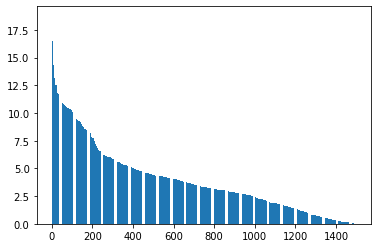

In [11]:
ratios = [np.log10(violator[2]) for violator in violators]
from matplotlib import pyplot as plt
plt.bar(np.arange(len(ratios)), ratios)

In [12]:
len(ratios), len(reactions)

(1500, 21327)

In [13]:
for violator in violators[:100]:
    rxn_string = str(violator[0])
    direction = {'forward':'=>','reverse':'<='}[violator[1]]
    ratio = violator[2]
    print(f"{rxn_string.replace('<=>',direction) :48s}  {ratio :.1g}")

HNO3(705) + S(1105) <= NO3(96) + S(1102)          5e+18
S(489) + S(1105) <= S(748) + S(1102)              1e+18
S(1105) + S(1032) <= S(1102) + S(125)             7e+16
H2NO4(269) + S(1105) <= HNO4(966) + S(1102)       3e+16
S(1105) + S(263) <= S(1102) + S(132)              3e+16
HNO3(705) + S(1105) <= NO3(96) + S(1102)          2e+16
S(489) + S(1105) <= S(748) + S(1102)              2e+15
HNO3(705) + HNO3(705) <= NO3(96) + H2NO3(244)     7e+14
S(1105) + S(1032) <= S(1102) + S(125)             2e+14
S(489) + S(1105) <= S(749) + S(1102)              2e+14
S(1105) + S(263) <= S(1102) + S(132)              2e+14
H2NO4(269) + S(1105) <= HNO4(966) + S(1102)       1e+14
HNO3(705) + S(445) <= NO3(96) + S(395)            3e+13
S(1105) + CH2OH(42) <= S(1102) + CH2O(13)         1e+13
HNO3(705) + HNO3(705) <= NO3(96) + H2NO3(244)     9e+12
S(489) + S(445) <= S(748) + S(395)                6e+12
H2NO3(245) + S(1105) <= HNO3(4) + S(1102)         5e+12
HNO3(705) + S(744) <= NO3(96) + S(622)          

In [14]:
from collections import Counter
import re

In [18]:
families = Counter()
templates = Counter()
rate_rules = Counter()
for violator in violators:
    rxn_string = str(violator[0])
    kinetics = violator[0].kinetics
    comment = ''
    if isinstance(violator[0], TemplateReaction):
        comment = violator[0].kinetics.comment
        violator[0].kinetics.comment = ''  # the comment is printed better when outside of the object
    if isinstance(violator[0], LibraryReaction):
        comment = 'Kinetic library: {0}'.format(violator[0].library)
    if isinstance(violator[0], PDepReaction):
        comment = 'Network #{0}'.format(violator[0].network)
    direction = violator[1]
    ratio = violator[2]
    condition = violator[3]
    
    m = re.search('family: (.*)', comment)
    if m:
        families[m.group(1)] += 1
    n = re.search('rate rule (.*)', comment)
    if n:
        rate_rules[m.group(1) + n.group(1)] += 1
    n = re.search('using template (\S+)', comment)
    if n:
        templates[m.group(1) + n.group(1)] += 1
    
    if ratio < 5:
        continue # only print the big ones!
        
    print('{0}\n{1}\n{2}\nDirection: {3}\nViolation factor: {4:.2g}\n'
                      'Violation condition: {5}\n\n'.format(rxn_string, kinetics, comment, direction,
                                                            ratio, condition))
    if isinstance(violator[0], TemplateReaction):
        # although this is the end of the run, restore the original comment
        violator[0].kinetics.comment = comment

HNO3(705) + S(1105) <=> NO3(96) + S(1102)
Arrhenius(A=(1.6e+06,'cm^3/(mol*s)'), n=1.87, Ea=(41.428,'kcal/mol'), T0=(1,'K'))
Estimated using template [Y_rad;O_Nrad] for rate rule [N5s_rad;O_Nrad]
Euclidian distance = 2.0
family: Disproportionation
Ea raised from 167.8 to 173.3 kJ/mol to match endothermicity of reaction.
Direction: reverse
Violation factor: 4.9e+18
Violation condition: 1000 K, 1.0 bar


S(489) + S(1105) <=> S(748) + S(1102)
Arrhenius(A=(1.6e+06,'cm^3/(mol*s)'), n=1.87, Ea=(14.354,'kcal/mol'), T0=(1,'K'))
Estimated using template [Y_rad;O_Nrad] for rate rule [N5s_rad;O_Nrad]
Euclidian distance = 2.0
family: Disproportionation
Ea raised from 53.4 to 60.1 kJ/mol to match endothermicity of reaction.
Direction: reverse
Violation factor: 1e+18
Violation condition: 1000 K, 1.0 bar


S(1105) + S(1032) <=> S(1102) + S(125)
Arrhenius(A=(1.6e+06,'cm^3/(mol*s)'), n=1.87, Ea=(14.54,'kcal/mol'), T0=(1,'K'))
Estimated using template [Y_rad;O_Nrad] for rate rule [N5s_rad;O_Nrad]
Euclidi

S(1973) + H2NO4(269) <=> HNO4(966) + S(1347)
Arrhenius(A=(1.6e+06,'cm^3/(mol*s)'), n=1.87, Ea=(34.677,'kcal/mol'), T0=(1,'K'))
Estimated using template [Y_rad;O_Nrad] for rate rule [N5s_rad;O_Nrad]
Euclidian distance = 2.0
family: Disproportionation
Ea raised from 142.6 to 145.1 kJ/mol to match endothermicity of reaction.
Direction: reverse
Violation factor: 6.4e+02
Violation condition: 423 K, 1.0 bar


HNOH(94) + S(489) <=> HNO(85) + S(429)
Arrhenius(A=(1.6e+06,'cm^3/(mol*s)'), n=1.87, Ea=(11.259,'kcal/mol'), T0=(1,'K'))
Estimated using template [Y_rad;O_Nrad] for rate rule [N5s_rad;O_Nrad]
Euclidian distance = 2.0
family: Disproportionation
Ea raised from 45.7 to 47.1 kJ/mol to match endothermicity of reaction.
Direction: reverse
Violation factor: 6.2e+02
Violation condition: 423 K, 1.0 bar


HNOH(94) + S(746) <=> HNO(85) + S(624)
Arrhenius(A=(1.6e+06,'cm^3/(mol*s)'), n=1.87, Ea=(11.259,'kcal/mol'), T0=(1,'K'))
Estimated using template [Y_rad;O_Nrad] for rate rule [N5s_rad;O_Nrad]
Eu

In [19]:
families.most_common(10)

[('Disproportionation', 1164),
 ('H_Abstraction', 35),
 ('R_Recombination', 16),
 ('CO_Disproportionation', 13),
 ('Cyclic_Ether_Formation', 4),
 ('1,4_Linear_birad_scission', 1)]

In [21]:
# This is what was used
templates.most_common(10)

[('Disproportionation[Y_rad;O_Nrad]', 547),
 ('Disproportionation[Y_rad;N3s/H2_s_Nrad]', 111),
 ('Disproportionation[Y_rad;NH_s_Rrad]', 78),
 ('Disproportionation[Y_rad;N3H_s_Rrad]', 75),
 ('Disproportionation[N3d_rad;O_Rrad]', 32),
 ('Disproportionation[N3s_rad;O_Nrad]', 31),
 ('Disproportionation[Y_rad;N3s/H2_s_Orad]', 22),
 ('Disproportionation[Y_rad;Cmethyl_Csrad]', 20),
 ('Disproportionation[Y_rad;O_Csrad]', 18),
 ('Disproportionation[Y_rad;N3s/H2_s_Nbirad]', 15)]

In [20]:
# This is what it was trying to use
rate_rules.most_common(10)

[('Disproportionation[N5s_rad;O_Nrad]', 527),
 ('Disproportionation[N5s_rad;N3s/H2_s_Nrad]', 110),
 ('Disproportionation[O_rad/NonDeN;O_Nrad]', 59),
 ('Disproportionation[N5s_rad;N3s/H/NonDe_s_Rrad]', 59),
 ('Disproportionation[N5s_rad;N5H_s_Rrad]', 54),
 ('Disproportionation[N3s_rad/NonDe2;O_Nrad]', 31),
 ('Disproportionation[N5s_rad;NH_s_Rrad]', 23),
 ('Disproportionation[N5s_rad;N3s/H2_s_Orad]', 22),
 ('Disproportionation[N3d_rad/N;O_Nrad]', 22),
 ('Disproportionation[N5s_rad;Cmethyl_Csrad]', 20)]